In [30]:
import os
import time
import random
import librosa
import kagglehub
import numpy as np
import matplotlib.pyplot as plt

In [31]:
path = kagglehub.dataset_download("skhalili/small-sound")

print("Path to dataset files:", path)

Path to dataset files: /home/capitan/.cache/kagglehub/datasets/skhalili/small-sound/versions/1


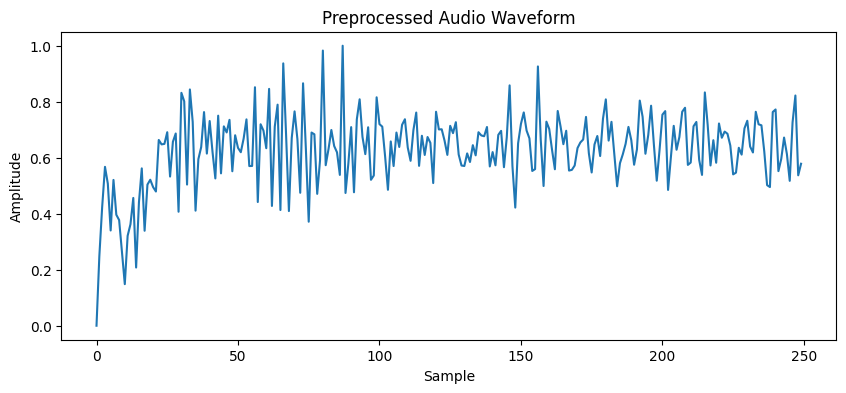

Audio Data Shape: (250,)
Flattened Audio Data Shape: (250,)


In [32]:
audio_length = 1 # e.g. 1 seconds
sample_rate = 250

start = time.time()

dataset_path = path

def preprocess_audio(audio_path, audio_length, sample_rate):
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    target_length = int(audio_length * sample_rate)
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        audio = audio[:target_length]

    audio = (audio - np.min(audio)) / (np.max(audio) - np.min(audio) + 1e-9)
    audio = audio.flatten()

    return audio

audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]
random_file = random.choice(audio_files)

current = preprocess_audio(random_file, audio_length, sample_rate)
N = current.size
Ni_size = N // 4  
Ne_size = N - Ni_size  

plt.figure(figsize=(10, 4))
plt.plot(current)
plt.title("Preprocessed Audio Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

print(f"Audio Data Shape: {current.shape}")
print(f"Flattened Audio Data Shape: {current.shape}")


In [33]:
# Params
Ne = current[:Ne_size]
Ni = current[Ne_size:]
thr = 30
time_span = 1000
re = np.random.rand(Ne_size,1)
ri = np.random.rand(Ni_size,1)
a = np.concatenate((0.02*np.ones((Ne_size,1)),0.02+0.08*ri))
b = np.concatenate((0.2*np.ones((Ne_size,1)),0.25-0.05*ri))
c = np.concatenate((-65+15*re**2,-65*np.ones((Ni_size,1))))
d = np.concatenate((8-6*re**2,2*np.ones((Ni_size,1))))
S = np.concatenate((0.5*np.random.rand(Ne_size+Ni_size,Ne_size),-np.random.rand(Ne_size+Ni_size,Ni_size)),1)
v = -65*np.ones((Ne_size+Ni_size,1)) 
u = b*v
print(Ne.shape, Ni.shape, S.shape)
spike_times = np.array([[0,0]])

(188,) (62,) (250, 250)


In [34]:
# Model
for t in range(time_span):
        # thalamic input
        I = np.concatenate((5 * current[:Ne_size].reshape(-1,1), 2 * current[Ne_size:].reshape(-1,1)),0)
        fired = np.where(v>=thr)[0]
        if fired is not None:
            firing = np.concatenate((t*np.ones((len(fired),1)),fired.reshape(-1,1)),1) 
            spike_times = np.concatenate((spike_times,firing))
            v[fired] = c[fired]
            u[fired] = u[fired] + d[fired]

            # add the contribution of the neurons that are spiking
            I += S[:,fired].sum(1).reshape(-1,1) 
        
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I) # dt = 0.5
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I) # dt = 0.5
        u = u + a*(b*v - u)


Simulation time: 0.0 min 20.52 sec 



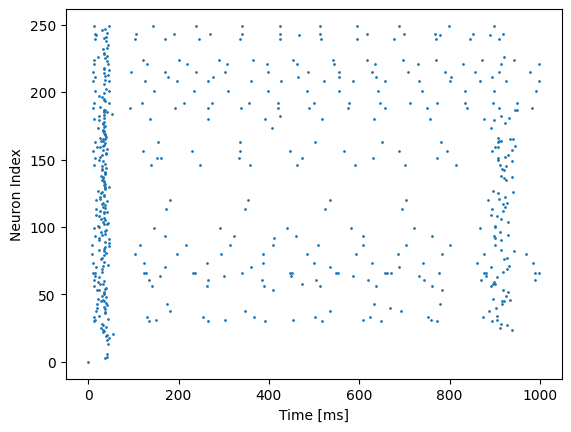

In [38]:
mins = (time.time()-start)//60
sec = (time.time()-start) % 60
print('Simulation time: {} min {:.2f} sec \n'.format(mins, sec))
plt.scatter(spike_times[:,0],spike_times[:,1],s=1)
plt.xlabel('Time [ms]')
plt.ylabel('Neuron Index')
plt.show()

(0.0, 1000.0)

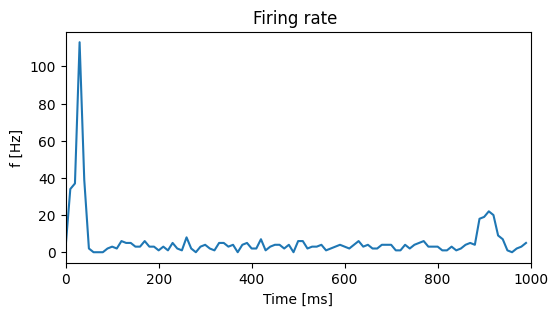

In [39]:
bin_size = 10
bins = np.arange(0, 1000 + bin_size, bin_size)
spike_counts, _ = np.histogram(spike_times[:,0], bins)
num_neurons = 100
firing_rate_timeseries = spike_counts / (bin_size / 1000.0 * num_neurons)
plt.figure(figsize=(6, 3))
plt.title('Firing rate ')
plt.plot(bins[:-1], firing_rate_timeseries, label='Firing Rate')
plt.xlabel('Time [ms]')
plt.ylabel('f [Hz]')
plt.xlim(0,1000)